In [1]:
!pip install torch openai-whisper google-cloud-speech google-cloud-texttospeech google-cloud-translate librosa soundfile pesq jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 15.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import re
import numpy as np
from google.cloud import speech, texttospeech, translate_v2 as translate
import whisper
import torch
import librosa
import soundfile as sf
from pesq import pesq
from jiwer import wer, cer

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/speech-understanding-457206-a2485146b69c.json"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Transcription with Whisper

In [5]:
import whisper
import os

def transcribe_with_whisper(audio_path, model_size="base"):
    print("Loading Whisper model...")
    model = whisper.load_model(model_size)
    print(f"Transcribing audio file: {audio_path}")
    result = model.transcribe(audio_path, language=None)  # Auto-detects language, supports code-switching
    transcript = result["text"]
    print("Transcription complete!")

    return transcript


### Using 40 mins of the last Speech Lecture

In [6]:
print("Step 1: Transcribing lecture...")
transcript = transcribe_with_whisper('/content/drive/MyDrive/audio.mp3')

Step 1: Transcribing lecture...
Loading Whisper model...


100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 89.5MiB/s]


Transcribing audio file: /content/drive/MyDrive/audio.mp3
Transcription complete!


In [7]:
transcript

" So, you are using my word also. So, online students, are you able to see the green model? So, some formulations, so they are going to be on the screen on the slide right. So, let us motivate about the speech synthesis. I am sure Dr. Chai has already talked about speech synthesis and then did actually classes, but we will go a little bit in detail here. So, in speech synthesis there are two major parts. The first part inspired by like you can get idea from this particular video. I am speaking English, but I am not in the bowl, but I am with Ola Pallare. I can speak French. Those are just a few examples of the different languages that I can speak here. So, now remember when our prime minister once actually used in Koder and decoder to speak in like give a life telecast in multiple languages in Talon, Thaleru, Kandara and all other languages. He does not know either of them, probably right, when he can speak so fluently neither of them, but then in the life telecast he was speaking, pro

In [8]:
with open("/content/drive/MyDrive/lecture_transcript.txt", "w", encoding="utf-8") as f:
    f.write(transcript)

In [9]:
def remove_filler_words(transcript):
    english_fillers = r'\b(um|uh|er|like|you know|so|basically|actually|literally|Um|Uh|So|Umm|Uhh|Like|Eh)\b'
    hindi_fillers = r'\b(मतलब|ऐसे|वो|तो|ना|हां|अच्छा)\b'
    # Remove filler words
    cleaned_transcript = re.sub(english_fillers, '', transcript, flags=re.IGNORECASE)
    cleaned_transcript = re.sub(hindi_fillers, '', cleaned_transcript)
    cleaned_transcript = re.sub(r'\s+', ' ', cleaned_transcript).strip()
    return cleaned_transcript

In [10]:
cleaned_transcript=remove_filler_words(transcript)

In [11]:
cleaned_transcript

", you are using my word also. , online students, are you able to see the green model? , some formulations, they are going to be on the screen on the slide right. , let us motivate about the speech synthesis. I am sure Dr. Chai has already talked about speech synthesis and then did classes, but we will go a little bit in detail here. , in speech synthesis there are two major parts. The first part inspired by you can get idea from this particular video. I am speaking English, but I am not in the bowl, but I am with Ola Pallare. I can speak French. Those are just a few examples of the different languages that I can speak here. , now remember when our prime minister once used in Koder and decoder to speak in give a life telecast in multiple languages in Talon, Thaleru, Kandara and all other languages. He does not know either of them, probably right, when he can speak fluently neither of them, but then in the life telecast he was speaking, probably he was not probably, he was speaking in H

In [12]:
with open("/content/drive/MyDrive/cleaned_lecture_transcript.txt", "w", encoding="utf-8") as f:
    f.write(cleaned_transcript)

## Audio Generation

In [13]:
!pip install pydub gtts googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.3 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=1ff6d7a2ef88b10eb4c49f249fdfd1a3492d1d0f00ce90a3277a154fad7e4c64
  Stored in directory: /root/.cache/pip/wheels/39/17/6f/66a045ea3d168826074691b4b787b8f324d3f646d755443fda
Successfully built googletrans
  Attempting uninstall: hyperframe
    Found existing installation: hyperframe 6.1.0
    Uninstalling hyperfram

Bengali samples in my own voice are extracted from a zip file to a folder

In [31]:
import zipfile
def extract_voice_samples(zip_file_path, extract_to="newer_voice_samples"):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            for zip_info in zip_ref.infolist():
                if zip_info.is_dir():
                    continue

                filename = os.path.basename(zip_info.filename)
                if not filename:
                    continue

                if filename.lower().endswith(('.mp4', '.m4a', '.wav', '.mp3')):
                    temp_path = os.path.join(extract_to, "temp_" + filename)

                    with zip_ref.open(zip_info) as source, open(temp_path, "wb") as target:
                        target.write(source.read())

                    try:
                        mp3_filename = os.path.splitext(filename)[0] + ".mp3"
                        mp3_path = os.path.join(extract_to, mp3_filename)
                        print(f"Converting {filename} to MP3...")
                        audio = AudioSegment.from_file(temp_path)
                        audio.export(mp3_path, format="mp3")

                        print(f"Converted: {mp3_path}")

                        os.remove(temp_path)
                    except Exception as e:
                        print(f"Error converting {filename}: {e}")
                else:
                    target_path = os.path.join(extract_to, filename)
                    with zip_ref.open(zip_info) as source, open(target_path, "wb") as target:
                        target.write(source.read())

        print(f"All files extracted and converted to MP3 in: {extract_to}")
        return extract_to

    except Exception as e:
        print(f"Error extracting voice samples: {e}")
        return None

In [48]:
import os
import librosa
import numpy as np
import tempfile
from pydub import AudioSegment

def extract_voice_features(voice_samples_folder):
    mp3_files = [os.path.join(voice_samples_folder, f) for f in os.listdir(voice_samples_folder)
                 if f.endswith('.mp3')]

    pitch_values = []
    speech_rate_values = []
    for mp3_file in mp3_files:
        print(f"Processing file: {mp3_file}")
        with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_wav_file:
            temp_wav = temp_wav_file.name

        audio = AudioSegment.from_mp3(mp3_file)
        audio.export(temp_wav, format="wav")

        try:
            y, sr = librosa.load(temp_wav, sr=None)

            #  PYIN for more reliable pitch estimation
            # This is better than piptrack for speech
            f0, voiced_flag, voiced_probs = librosa.pyin(
                y,
                fmin=librosa.note_to_hz('C2'),
                fmax=librosa.note_to_hz('C7'),
                sr=sr
            )

            valid_f0 = f0[voiced_flag & (f0 > 0)]

            if len(valid_f0) > 0:
                pitch_avg = np.mean(valid_f0)
                pitch_values.append(pitch_avg)
                print(f"Extracted pitch for {os.path.basename(mp3_file)}: {pitch_avg:.2f} Hz")
            else:
                print(f"No valid pitch detected for {os.path.basename(mp3_file)}")

            # Calculate speech rate based on syllable-like energy variations
            # First, compute the envelope of the signal
            envelope = np.abs(y)

            #  low pass filter to smooth the envelope
            envelope = librosa.util.normalize(envelope)
            envelope = librosa.effects.preemphasis(envelope)

            # Find peaks in the envelope that could correspond to syllables
            peaks = librosa.util.peak_pick(envelope, pre_max=3, post_max=3,
                                         pre_avg=3, post_avg=5, delta=0.1, wait=10)

            # Calculate syllables per second
            duration = len(y) / sr  # Duration in seconds
            if duration > 0:
                speech_rate = len(peaks) / duration
                speech_rate_values.append(speech_rate)
                print(f"Extracted speech rate for {os.path.basename(mp3_file)}: {speech_rate:.2f} syllables/sec")
            else:
                print(f"Invalid duration for {os.path.basename(mp3_file)}")

        except Exception as e:
            print(f"Error processing {os.path.basename(mp3_file)}: {e}")

        finally:
            if os.path.exists(temp_wav):
                os.remove(temp_wav)

    if pitch_values:
        avg_pitch = np.mean(pitch_values)
        min_pitch = np.min(pitch_values)
        max_pitch = np.max(pitch_values)
        pitch_variation = max_pitch - min_pitch
        print(f"\nPitch statistics across {len(pitch_values)} files:")
        print(f"Average: {avg_pitch:.2f} Hz")
        print(f"Range: {min_pitch:.2f} - {max_pitch:.2f} Hz")
        print(f"Variation: {pitch_variation:.2f} Hz")
    else:
        print("No valid pitch measurements obtained")
        avg_pitch = 160  # Typical default for adult human speech

    if speech_rate_values:
        avg_speech_rate = np.mean(speech_rate_values)
        min_rate = np.min(speech_rate_values)
        max_rate = np.max(speech_rate_values)
        rate_variation = max_rate - min_rate
        print(f"\nSpeech rate statistics across {len(speech_rate_values)} files:")
        print(f"Average: {avg_speech_rate:.2f} syllables/sec")
        print(f"Range: {min_rate:.2f} - {max_rate:.2f} syllables/sec")
        print(f"Variation: {rate_variation:.2f} syllables/sec")
    else:
        print("No valid speech rate measurements obtained")
        avg_speech_rate = 4.0  # Typical default syllables per second


    pitch_factor = avg_pitch /160.0
    speed_factor = avg_speech_rate /4.0

    print(f"\nFinal factors:")
    print(f"Pitch factor: {pitch_factor:.3f}")
    print(f"Speed factor: {speed_factor:.3f}")

    return {
        "pitch_factor": pitch_factor,
        "speed_factor": speed_factor,
        "raw_pitch": avg_pitch,
        "raw_speech_rate": avg_speech_rate,
        "pitch_variation": pitch_variation if 'pitch_variation' in locals() else 0,
        "rate_variation": rate_variation if 'rate_variation' in locals() else 0
    }

In [16]:
!pip install gTTS

In [17]:
pip install google-cloud-translate

Convert bengali text to speech

In [33]:
import os
import numpy as np
from pydub import AudioSegment
from gtts import gTTS
from google.cloud import translate_v2 as translate  # Import Google Cloud Translate


def basic_bengali_tts(bengali_text, output_file="basic_bengali_tts.mp3"):
    tts = gTTS(text=bengali_text, lang='bn', slow=False)
    tts.save(output_file)
    print(f"Basic Bengali TTS saved to {output_file}")
    return output_file

Transform to my vioce

In [52]:
import librosa
import numpy as np
import tempfile
import os
from pydub import AudioSegment
import soundfile as sf

def adapt_voice_simple(tts_audio_path, voice_features, output_file, chunk_sec=30):
    print(f"Adapting voice with features: {voice_features}")

    y, sr = librosa.load(tts_audio_path, sr=None)

    # Calculate pitch shift in semitones based on the pitch factor
    raw_steps = 12 * np.log2(voice_features["pitch_factor"])
    pitch_semitones = float(np.clip(raw_steps, -3, 3))  # Clamp to a reasonable range
    print(f"Shifting pitch by {pitch_semitones:.2f} semitones")

    # Apply pitch shift
    y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=pitch_semitones)

    # Apply speed adjustment (adjusting speed without changing pitch)
    speed_factor = float(np.clip(voice_features["speed_factor"], 0.8, 1.2))
    print(f"Applying speed factor: {speed_factor:.2f}×")
    if abs(speed_factor - 1.0)> 0.02:
        y_shifted = librosa.effects.time_stretch(y_shifted, rate=speed_factor)

    sf.write("temp.wav", y_shifted, sr)

    AudioSegment.from_wav("temp.wav").export(output_file, format="mp3")
    print(f"Voice-adapted audio saved to {output_file}")
    os.remove("temp.wav")

    return output_file

This translates the text to bengali only

In [35]:
def translate_to_bengali(text_to_translate):
    translate_client = translate.Client()
    try:
        result = translate_client.translate(text_to_translate, target_language="bn")
        bengali_text = result["translatedText"]
        print(f"Bengali translation: {bengali_text}")
        return bengali_text
    except Exception as e:
        print(f"Translation error: {e}")
        print("Using original text as fallback.")
        return text_to_translate

In [41]:
def process_bengali_tts(text_to_translate, zip_file_path):
    voice_samples_folder = extract_voice_samples(zip_file_path)
    if not voice_samples_folder:
        print("Failed to extract voice samples. Using basic TTS without adaptation.")
        return basic_bengali_tts(text_to_translate)

    # Translate to Bengali
    bengali_text = translate_to_bengali(text_to_translate)

    # Generate basic Bengali TTS
    print("Generating basic Bengali TTS...")
    temp_tts = basic_bengali_tts(bengali_text, "temp_bengali_tts.mp3")

    # Extract voice features from samples
    print("Extracting voice features from your recordings...")
    voice_features = extract_voice_features(voice_samples_folder)
    print(f"Extracted voice features: {voice_features}")


In [39]:
zip_path = "/content/drive/MyDrive/bengali_samples.zip"
output_audio = process_bengali_tts(cleaned_transcript, zip_path)

Converting b1.mp4 to MP3...
Converted: newer_voice_samples/b1.mp3
Converting b10.mp4 to MP3...
Converted: newer_voice_samples/b10.mp3
Converting b2.mp4 to MP3...
Converted: newer_voice_samples/b2.mp3
Converting b3.mp4 to MP3...
Converted: newer_voice_samples/b3.mp3
Converting b4.mp4 to MP3...
Converted: newer_voice_samples/b4.mp3
Converting b5.mp4 to MP3...
Converted: newer_voice_samples/b5.mp3
Converting b6.mp4 to MP3...
Converted: newer_voice_samples/b6.mp3
Converting b7.mp4 to MP3...
Converted: newer_voice_samples/b7.mp3
Converting b8.mp4 to MP3...
Converted: newer_voice_samples/b8.mp3
Converting b9.mp4 to MP3...
Converted: newer_voice_samples/b9.mp3
Converting WhatsApp Audio 2025-04-18 at 15.33.25.mp4 to MP3...
Converted: newer_voice_samples/WhatsApp Audio 2025-04-18 at 15.33.25.mp3
Converting WhatsApp Audio 2025-04-18 at 15.33.26.mp4 to MP3...
Converted: newer_voice_samples/WhatsApp Audio 2025-04-18 at 15.33.26.mp3
All files extracted and converted to MP3 in: newer_voice_samples
B

KeyboardInterrupt: 

Just doing it again here

In [49]:
# Step 4: Extract voice features from samples
print("Extracting voice features from your recordings...")
voice_features = extract_voice_features('newer_voice_samples/')
print(f"Extracted voice features: {voice_features}")

Extracting voice features from your recordings...
Processing file: newer_voice_samples/b4.mp3
Extracted pitch for b4.mp3: 259.37 Hz
Extracted speech rate for b4.mp3: 8.55 syllables/sec
Processing file: newer_voice_samples/b2.mp3
Extracted pitch for b2.mp3: 220.90 Hz
Extracted speech rate for b2.mp3: 29.36 syllables/sec
Processing file: newer_voice_samples/b7.mp3
Extracted pitch for b7.mp3: 245.79 Hz
Extracted speech rate for b7.mp3: 46.18 syllables/sec
Processing file: newer_voice_samples/b6.mp3
Extracted pitch for b6.mp3: 257.54 Hz
Extracted speech rate for b6.mp3: 9.34 syllables/sec
Processing file: newer_voice_samples/b1.mp3
Extracted pitch for b1.mp3: 264.93 Hz
Extracted speech rate for b1.mp3: 1.25 syllables/sec
Processing file: newer_voice_samples/b9.mp3
Extracted pitch for b9.mp3: 248.24 Hz
Extracted speech rate for b9.mp3: 1.37 syllables/sec
Processing file: newer_voice_samples/b3.mp3
Extracted pitch for b3.mp3: 276.74 Hz
Extracted speech rate for b3.mp3: 1.10 syllables/sec
Pro

In [53]:
print("Applying voice adaptation...")
output_file = "/content/bengali_with_my_voice.mp3"
final_output = adapt_voice_simple('/content/temp_bengali_tts.mp3', voice_features, output_file)


Applying voice adaptation...
Adapting voice with features: {'pitch_factor': np.float64(1.5759762598470133), 'speed_factor': np.float64(4.989950692874741), 'raw_pitch': np.float64(252.15620157552212), 'raw_speech_rate': np.float64(19.959802771498964), 'pitch_variation': np.float64(55.84692576956067), 'rate_variation': np.float64(70.27428890881447)}
Shifting pitch by 3.00 semitones
Applying speed factor: 1.20×
Voice-adapted audio saved to /content/bengali_with_my_voice.mp3


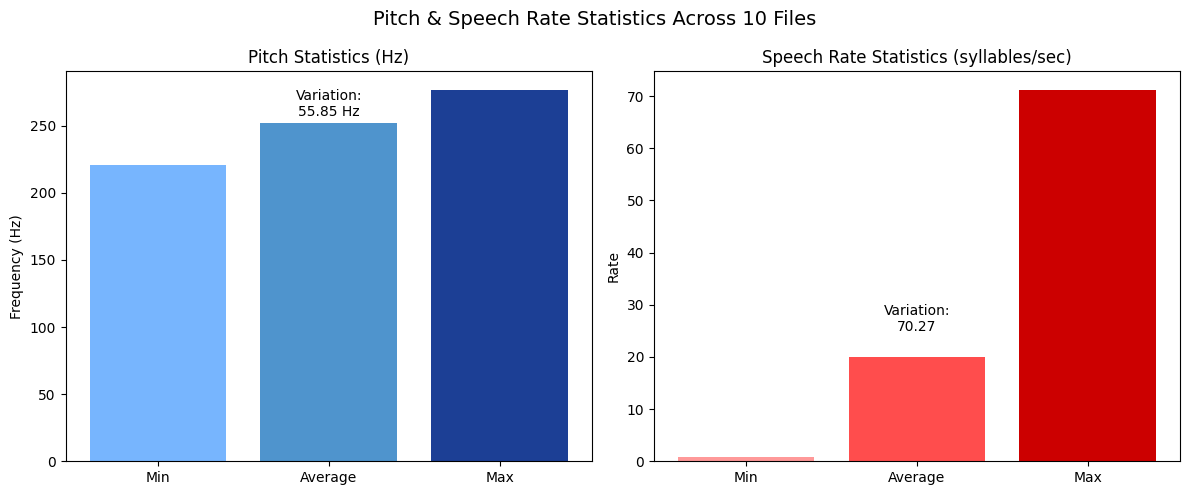

In [1]:
import matplotlib.pyplot as plt
import numpy as np
pitch_stats = {
    "Average": 252.16,
    "Min": 220.90,
    "Max": 276.74,
    "Variation": 55.85
}

speech_rate_stats = {
    "Average": 19.96,
    "Min": 0.91,
    "Max": 71.18,
    "Variation": 70.27
}

final_factors = {
    "Pitch factor": 1.576,
    "Speed factor": 4.990
}

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].bar(["Min", "Average", "Max"], [pitch_stats["Min"], pitch_stats["Average"], pitch_stats["Max"]], color=["#77b5fe", "#4f94cd", "#1c3f95"])
axs[0].set_title("Pitch Statistics (Hz)")
axs[0].set_ylabel("Frequency (Hz)")
axs[0].annotate(f'Variation:\n{pitch_stats["Variation"]:.2f} Hz', xy=(1, pitch_stats["Average"] + 5), ha='center', fontsize=10)

axs[1].bar(["Min", "Average", "Max"], [speech_rate_stats["Min"], speech_rate_stats["Average"], speech_rate_stats["Max"]], color=["#ff9999", "#ff4d4d", "#cc0000"])
axs[1].set_title("Speech Rate Statistics (syllables/sec)")
axs[1].set_ylabel("Rate")
axs[1].annotate(f'Variation:\n{speech_rate_stats["Variation"]:.2f}', xy=(1, speech_rate_stats["Average"] + 5), ha='center', fontsize=10)

plt.suptitle("Pitch & Speech Rate Statistics Across 10 Files", fontsize=14)
plt.tight_layout()

plt.show()


## Evaluation

In [54]:
!pip install google-cloud-speech

Using Google STT

In [60]:
from pydub import AudioSegment
from google.cloud import speech
import os
import math
import tempfile

def transcribe_bilingual_audio_to_file(audio_path, output_path, chunk_sec=30):
    audio = AudioSegment.from_file(audio_path)
    audio = audio.set_channels(1)  # Convert to mono
    chunk_ms = chunk_sec * 1000  # in milliseconds
    total_ms = len(audio)
    n_chunks = math.ceil(total_ms / chunk_ms)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    client = speech.SpeechClient()

    with open(output_path, "w", encoding="utf-8") as out_f:
        for i in range(n_chunks):
            start_ms = i * chunk_ms
            end_ms   = min((i + 1) * chunk_ms, total_ms)
            chunk = audio[start_ms:end_ms]

            # Export chunk to a temporary WAV file (Linear16)
            with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp_wav:
                chunk.export(tmp_wav.name, format="wav")
                tmp_path = tmp_wav.name

            with open(tmp_path, "rb") as wav_f:
                wav_bytes = wav_f.read()

            audio_config = speech.RecognitionConfig(
                encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
                sample_rate_hertz=48000,
                language_code="en-US",
                alternative_language_codes=["hi-IN"],
                enable_automatic_punctuation=True
            )
            audio_req = speech.RecognitionAudio(content=wav_bytes)


            print(f"Transcribing chunk {i+1}/{n_chunks} ({start_ms/1000:.0f}s–{end_ms/1000:.0f}s)...")
            response = client.recognize(config=audio_config, audio=audio_req)
            for result in response.results:
                out_f.write(result.alternatives[0].transcript.strip() + "\n")
            os.remove(tmp_path)

    print(f"✅ Full transcript saved to {output_path}")

transcribe_bilingual_audio_to_file(
    audio_path="/content/drive/MyDrive/audio.mp3",
    output_path="/content/drive/MyDrive/base_transcript.txt",
    chunk_sec=30  # 30s chunks to stay well under the 10 MB limit
)



Transcribing chunk 1/81 (0s–30s)...
Transcribing chunk 2/81 (30s–60s)...
Transcribing chunk 3/81 (60s–90s)...
Transcribing chunk 4/81 (90s–120s)...
Transcribing chunk 5/81 (120s–150s)...
Transcribing chunk 6/81 (150s–180s)...
Transcribing chunk 7/81 (180s–210s)...
Transcribing chunk 8/81 (210s–240s)...
Transcribing chunk 9/81 (240s–270s)...
Transcribing chunk 10/81 (270s–300s)...
Transcribing chunk 11/81 (300s–330s)...
Transcribing chunk 12/81 (330s–360s)...
Transcribing chunk 13/81 (360s–390s)...
Transcribing chunk 14/81 (390s–420s)...
Transcribing chunk 15/81 (420s–450s)...
Transcribing chunk 16/81 (450s–480s)...
Transcribing chunk 17/81 (480s–510s)...
Transcribing chunk 18/81 (510s–540s)...
Transcribing chunk 19/81 (540s–570s)...
Transcribing chunk 20/81 (570s–600s)...
Transcribing chunk 21/81 (600s–630s)...
Transcribing chunk 22/81 (630s–660s)...
Transcribing chunk 23/81 (660s–690s)...
Transcribing chunk 24/81 (690s–720s)...
Transcribing chunk 25/81 (720s–750s)...
Transcribing chun

In [63]:
import re
def remove_filler_words_from_file(file_path, output_path):
    english_fillers = r'\b(um|uh|er|like|you know|so|basically|actually|literally|Um|Uh|So|Umm|Uhh|Like|Eh)\b'
    hindi_fillers = r'\b(मतलब|ऐसे|वो|तो|ना|हां|अच्छा)\b'
    with open(file_path, 'r', encoding='utf-8') as file:
        transcript = file.read()

    cleaned_transcript = re.sub(english_fillers, '', transcript, flags=re.IGNORECASE)
    cleaned_transcript = re.sub(hindi_fillers, '', cleaned_transcript)
    cleaned_transcript = re.sub(r'\s+', ' ', cleaned_transcript).strip()

    with open(output_path, 'w', encoding='utf-8') as file:
        file.write(cleaned_transcript)

    print(f"Filler words removed. Cleaned transcript saved to {output_path}")




In [64]:
remove_filler_words_from_file(
    file_path="/content/drive/MyDrive/base_transcript.txt",  # original transcript file
    output_path="/content/drive/MyDrive/cleaned_base_transcript.txt"  #  cleaned transcript
)

Filler words removed. Cleaned transcript saved to /content/drive/MyDrive/cleaned_base_transcript.txt


In [2]:
!pip install pesq pystoi jiwer

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.1 MB/s eta 0:00:00
  Created wheel for pesq: filename=pesq-0.0.4-cp311-cp311-linux_x86_64.whl size=274949 sha256=1425ceb5f2a3cabca17e4f4de008b083b25b1d4ee31453f104efc6e376e167ca
  Stored in directory: /root/.cache/pip/wheels/ae/f1/23/2698d0bf31eec2b2aa50623b5d93b6206c49c7155d0e31345d
Successfully built pesq


In [3]:
pip install pydub

In [3]:
from pesq import pesq
from scipy.io import wavfile

from pydub import AudioSegment

def convert_mp3_to_wav(input_path, output_path, target_sample_rate=16000):
    audio = AudioSegment.from_mp3(input_path)
    audio = audio.set_frame_rate(target_sample_rate).set_channels(1)  # mono, 16kHz
    audio.export(output_path, format="wav")

# Example usage
convert_mp3_to_wav("/content/temp_bengali_tts.mp3", "original.wav")
convert_mp3_to_wav("/content/bengali_with_my_voice.mp3", "generated.wav")


In [22]:
from pydub import AudioSegment
from scipy.io import wavfile
from pesq import pesq
import os
import numpy as np

def convert_mp3_to_wav(input_path, output_path, target_sample_rate=16000):
    audio = AudioSegment.from_mp3(input_path)
    audio = audio.set_frame_rate(target_sample_rate).set_channels(1)
    audio.export(output_path, format="wav")

def clip_to_10_minutes(audio_path, output_path, max_duration_ms=600000):
    audio = AudioSegment.from_wav(audio_path)
    clipped = audio[:max_duration_ms]
    clipped.export(output_path, format="wav")

def split_audio(audio_path, chunk_length_ms=50000):
    audio = AudioSegment.from_wav(audio_path)
    chunks = []
    for i in range(0, len(audio), chunk_length_ms):
        chunk = audio[i:i + chunk_length_ms]
        chunk_path = f"{audio_path}_chunk_{i//chunk_length_ms}.wav"
        chunk.export(chunk_path, format="wav")
        chunks.append(chunk_path)
    return chunks

def compute_pesq_on_chunks(ref_chunks, deg_chunks):
    pesq_scores = []
    for ref_path, deg_path in zip(ref_chunks, deg_chunks):
        rate_ref, ref = wavfile.read(ref_path)
        rate_deg, deg = wavfile.read(deg_path)
        if rate_ref != 16000 or rate_deg != 16000:
            print(f"Skipping due to wrong sampling rate: {ref_path}")
            continue
        try:
            score = pesq(rate_ref, ref, deg, 'wb')
            pesq_scores.append(score)
        except Exception as e:
            print(f"Error in chunk {ref_path}: {e}")
    return np.mean(pesq_scores) if pesq_scores else None




### PESQ scores between gTTS Bengali speech and transformed (to my voice) Bengali speech

In [23]:
convert_mp3_to_wav("/content/temp_bengali_tts.mp3", "original_full.wav")
convert_mp3_to_wav("/content/bengali_with_my_voice.mp3", "generated_full.wav")

In [24]:
clip_to_10_minutes("original_full.wav", "original.wav")
clip_to_10_minutes("generated_full.wav", "generated.wav")

In [25]:
original_chunks = split_audio("original.wav")
generated_chunks = split_audio("generated.wav")

In [26]:
min_len = min(len(original_chunks), len(generated_chunks))
avg_pesq = compute_pesq_on_chunks(original_chunks[:min_len], generated_chunks[:min_len])

print(f"\nAverage PESQ score (first 10 mins): {avg_pesq:.3f}" if avg_pesq else " No PESQ score calculated.")


Average PESQ score (first 10 mins): 1.041


### PESQ scores between original lecturer's speech (English + Hindi) and transformed (to my voice) Bengali speech

In [27]:
convert_mp3_to_wav("/content/audio.mp3", "original_full.wav")
convert_mp3_to_wav("/content/bengali_with_my_voice.mp3", "generated_full.wav")

In [28]:
clip_to_10_minutes("original_full.wav", "original.wav")
clip_to_10_minutes("generated_full.wav", "generated.wav")

In [29]:
original_chunks = split_audio("original.wav")
generated_chunks = split_audio("generated.wav")

In [30]:
min_len = min(len(original_chunks), len(generated_chunks))
avg_pesq = compute_pesq_on_chunks(original_chunks[:min_len], generated_chunks[:min_len])

print(f"\nAverage PESQ score (first 10 mins): {avg_pesq:.3f}" if avg_pesq else " No PESQ score calculated.")


Average PESQ score (first 10 mins): 1.282


### WER and CER between Google Cloud TTS transcription (base reference) and Whisper transcription

In [31]:
from jiwer import wer, cer

def compute_error_rates(reference_text, hypothesis_text):
    word_error = wer(reference_text, hypothesis_text)
    char_error = cer(reference_text, hypothesis_text)
    return word_error, char_error

# Example usage:
with open("/content/drive/MyDrive/cleaned_base_transcript.txt", "r", encoding="utf-8") as ref_file:
    reference = ref_file.read()

with open("/content/drive/MyDrive/cleaned_lecture_transcript.txt", "r", encoding="utf-8") as hyp_file:
    hypothesis = hyp_file.read()

wer_score, cer_score = compute_error_rates(reference, hypothesis)
print(f"WER: {wer_score:.4f}")
print(f"CER: {cer_score:.4f}")


WER: 0.6751
CER: 0.4673
